In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import pdb
from stable_baselines3 import PPO, A2C, HER, SAC, DDPG
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3.common.monitor import Monitor

In [2]:
'''
TrackMDP Environment (basic version):
'''

import gymnasium as gym
import numpy as np
from gymnasium import spaces

class TrackMDPEnv(gym.Env):
    """
    grid_size (int): The width and height of the square grid.
    n_cells (int): Total number of cells in the grid (grid_size * grid_size).
    T_max (int): Maximum number of steps the target can be unobserved
                    before a safe-sensing action is enforced[cite: 176].
    r (float): Reward value for successfully detecting the target[cite: 165].
    c (float): Cost incurred for each activated sensor[cite: 165].
    exit_prob (float): Probability of the target exiting the grid at each step.
    """
    metadata = {"render_modes": ["human", "ansi"], "render_fps": 4}

    def __init__(self, grid_size=5, T_max=10, r=1.0, c=0.1, d=10, exit_prob=0.01):
        super().__init__()

        self.grid_size = grid_size
        self.n_cells = grid_size * grid_size
        self.T_max = T_max
        self.r = r
        self.c = c
        self.d = d
        self.exit_prob = exit_prob
        self.action_space = spaces.MultiBinary(self.n_cells)
        self.observation_space = spaces.Dict({
            "last_known_pos": spaces.Discrete(self.n_cells), # position in grid
            "time_since_observed": spaces.Discrete(T_max + 2), # +1 for exit state
            "list of past actions": spaces.MultiBinary(self.n_cells * (T_max + 1)) # Flattened list of past actions
        })
        # Internal state
        self._target_pos = None
        self._last_known_pos = None
        self._time_since_observed = None
        self._past_actions = None
        self._render_grid = None
        self.render_mode = "human"

    def _get_obs(self):
        return {
            "last_known_pos": self._last_known_pos,
            "time_since_observed": self._time_since_observed,
            "list of past actions": self._past_actions.flatten() if self._past_actions is not None else np.zeros(self.n_cells * (self.T_max + 1), dtype=int)
        }

    def _get_info(self):
        return {
            "target_pos": self._target_pos,
            "is_found": self._time_since_observed == 0
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)


        # position x_0 is known
        self._target_pos = self.np_random.integers(0, self.n_cells)
        self._last_known_pos = self._target_pos
        self._time_since_observed = 0
        self._past_actions = np.zeros((self.T_max + 1, self.n_cells), dtype=int)

        return self._get_obs(), self._get_info()

    def _move_target(self):
        """
        Target's movement is random as it is not known to the agent.
        """
        if self.np_random.random() < self.exit_prob:
            self._target_pos = -1 # Target exits the grid
            return

        row, col = self._target_pos // self.grid_size, self._target_pos % self.grid_size # derive row, col
        
        # Possible moves: up, down, left, right, stay
        moves = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]
        move = self.np_random.choice(len(moves))
        d_row, d_col = moves[move]

        new_row = np.clip(row + d_row, 0, self.grid_size - 1)
        new_col = np.clip(col + d_col, 0, self.grid_size - 1)

        self._target_pos = new_row * self.grid_size + new_col


    def step(self, action):
        '''
        Step funciton for the TrackMDP environment.        
        '''
        # step is an update of P and R based on action a
        # D is not explicitly defined
        is_safe_sensing = self._time_since_observed >= self.T_max + 1
        if is_safe_sensing:
            action = np.ones(self.n_cells, dtype=int) # Activate all sensors

        # 1. Target moves according to hidden Markov process
        self._move_target()

        terminated = self._target_pos == -1
        
        # 2. Calculate reward
        reward = 0
        is_found = False

        if is_safe_sensing: # Penalty for safe-sensing
            reward = -self.d
        
        if not terminated:
            num_active_sensors = np.sum(action)
            cost = self.c * num_active_sensors
            
            # Check if the sensor at the target's new position was activated 
            if action[self._target_pos] == 1:
                is_found = True
                reward = self.r
            
            reward -= cost

        # 3. Update state
        if is_found:
            self._last_known_pos = self._target_pos
            self._time_since_observed = 0
        elif not terminated:
            self._time_since_observed += 1

        # Update past actions
        if self._time_since_observed <= self.T_max and not (is_found): # Only update if within T_max
            if self._past_actions is None: # Initialize if not already
                self._past_actions = np.zeros((self.T_max + 1, self.n_cells), dtype=int)
            if self._past_actions is not None: # Shift and add new action
                self._past_actions = np.roll(self._past_actions, shift=-1, axis=0)
                self._past_actions[-1] = action
        else: # Reset past actions if exceeded T_max
            self._past_actions = np.zeros((self.T_max + 1, self.n_cells), dtype=int)
            self._past_actions = np.roll(self._past_actions, shift=-1, axis=0)
            self._past_actions[-1] = action
        
        
        truncated = False
        info = self._get_info()
        obs = self._get_obs()
        
        self._render_grid = self._make_render_grid(action)

        return obs, reward, terminated, truncated, info

# AI generated rendering function
    def _make_render_grid(self, action):
        grid = np.full((self.grid_size, self.grid_size), '·', dtype=str)
        
        # Mark active sensors
        for i, sensor_on in enumerate(action):
            if sensor_on:
                row, col = i // self.grid_size, i % self.grid_size
                grid[row, col] = 'o'
                
        # Mark last known position
        lkp_row, lkp_col = self._last_known_pos // self.grid_size, self._last_known_pos % self.grid_size
        grid[lkp_row, lkp_col] = 'L'
        
        # Mark target's true position
        if self._target_pos != -1:
            tgt_row, tgt_col = self._target_pos // self.grid_size, self._target_pos % self.grid_size
            # If target is at the same spot as last known, mark it 'T'
            if self._target_pos == self._last_known_pos:
                grid[tgt_row, tgt_col] = 'T'
            else: # If target is elsewhere, mark it 'X'
                grid[tgt_row, tgt_col] = 'X'
        
        # If an active sensor found the target
        if self._time_since_observed == 0 and self._target_pos != -1:
             tgt_row, tgt_col = self._target_pos // self.grid_size, self._target_pos % self.grid_size
             grid[tgt_row, tgt_col] = '✓'
             
        return grid


    def render(self, render_mode="human"):
        if self._render_grid is None:
             self._render_grid = self._make_render_grid(np.zeros(self.n_cells))

        grid_str = "\n".join(" ".join(row) for row in self._render_grid)
        
        print(f"Time since observed: {self._time_since_observed}")
        print(grid_str)
        print("Legend: · Empty | o Active Sensor | L Last Known | X True Position | ✓ Found!")
        print("-" * 20)

Using cpu device
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 110      |
|    ep_rew_mean        | -151     |
| time/                 |          |
|    fps                | 3046     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -17      |
|    explained_variance | -0.0364  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -76.8    |
|    value_loss         | 51.1     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 91.4     |
|    ep_rew_mean        | -116     |
| time/                 |          |
|    fps                | 3254     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps   

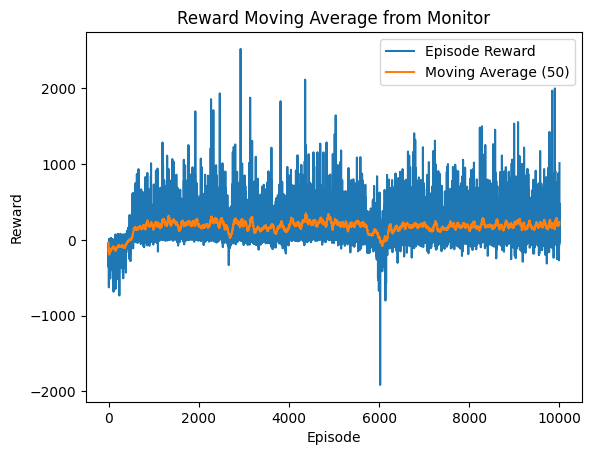

In [3]:

env = TrackMDPEnv(grid_size=5, T_max=5, r=10.0, c=0.5)
env = Monitor(env, "./logs")
model = A2C("MultiInputPolicy", env, verbose=1)
model.learn(total_timesteps=1000000)

df = pd.read_csv("./logs.monitor.csv", skiprows=1)
rewards = df["r"]
plt.plot(rewards = df["r"])
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards")

window_size = 50
moving_avg = rewards.rolling(window=window_size, min_periods=1).mean()

# Plot
plt.plot(rewards.index, rewards, label='Episode Reward')
plt.plot(moving_avg.index, moving_avg, label=f'Moving Average ({window_size})')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('Reward Moving Average from Monitor')

plt.show()

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 106      |
|    ep_rew_mean     | -120     |
| time/              |          |
|    fps             | 6787     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 107         |
|    ep_rew_mean          | -124        |
| time/                   |             |
|    fps                  | 4854        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012623905 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -17.3       |
|    explained_varia

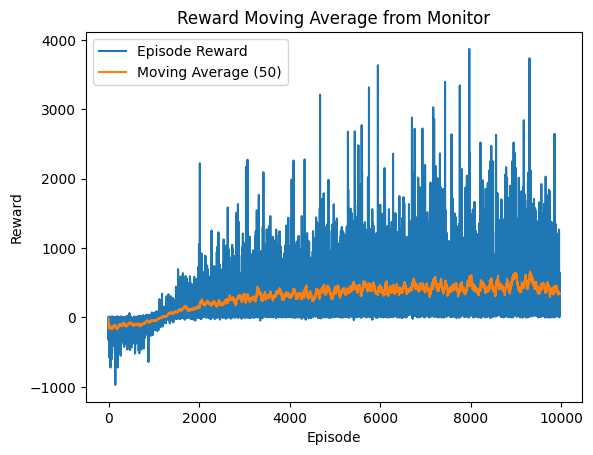

In [4]:

env = TrackMDPEnv(grid_size=5, T_max=5, r=10.0, c=0.5)
env = Monitor(env, "./logs")
model = PPO("MultiInputPolicy", env, verbose=1)
model.learn(total_timesteps=1000000)

df = pd.read_csv("./logs.monitor.csv", skiprows=1)
rewards = df["r"]
plt.plot(rewards = df["r"])
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards")

window_size = 50
moving_avg = rewards.rolling(window=window_size, min_periods=1).mean()

# Plot
plt.plot(rewards.index, rewards, label='Episode Reward')
plt.plot(moving_avg.index, moving_avg, label=f'Moving Average ({window_size})')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('Reward Moving Average from Monitor')

plt.show()